In [2]:
import librosa
import librosa.display
import numpy as np
import os
import pickle
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization


2025-06-23 07:01:42.994431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750654903.019718  260215 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750654903.027892  260215 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 07:01:43.053431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
def extract_mlp_features(audio_path, sr=22050, n_mfcc=20, n_fft=2048, hop_length=512):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except Exception as e:
        print(f"Napaka pri nalaganju {audio_path}: {e}")
        return None

    features = []

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    features.extend(np.mean(mfccs, axis=1)) # Povprečimo čez vsa okna
    # Centroid spektralne energije. Pove nam, kje je "težišče" zvoka.
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    features.append(np.mean(spec_centroid))
    # Širina frekvenčnega pasu, ki vsebuje določen odstotek energije.
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    features.append(np.mean(spec_bandwidth))
    # Frekvenca pod katero je določen odstotek (npr. 85%) skupne spektralne energije.
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    features.append(np.mean(spec_rolloff))
    # Število prehodov signala skozi ničlo na časovno enoto. Pomembno za ritem in vokalne lastnosti.
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=n_fft, hop_length=hop_length)
    features.append(np.mean(zcr))
    # Predstavlja 12 različnih tonskih razredov (note), ki se pojavljajo v glasbi.
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    features.extend(np.mean(chroma_stft, axis=1))
    # Meritev glasnosti signala.
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    features.append(np.mean(rms))

    return np.array(features)

def extract_cnn_features_mel_spectrogram(audio_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except Exception as e:
        print(f"Napaka pri nalaganju {audio_path}: {e}")
        return None

    # Izračun Mel-spektrograma
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    # Pretvorba v log-skalo (dB) za boljšo vizualizacijo in stabilnost učenja
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [3]:

def build_mlp_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=input_shape),
        BatchNormalization(), # Pomaga pri stabilnosti in konvergenci učenja
        Dropout(0.3),         # Pomaga preprečiti prekomerno učenje (overfitting)

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation='softmax') # Softmax za večrazredno klasifikacijo
    ])
    return model

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Prvi konvolucijski blok
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Drugi konvolucijski blok
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Tretji konvolucijski blok
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(), # Pretvorimo 2D mapo značilnic v 1D vektor

        # Gostiljski sloji (podobno kot v MLP)
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), # Večji dropout, ker je zdaj flattening

        Dense(num_classes, activation='softmax')
    ])
    return model

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pickle

def load_gtzan_data(data_dir):
    """
    Naloži poti do zvočnih datotek in njihove žanre iz GTZAN nabora.
    """
    filepaths = []
    labels = []
    genres = sorted(os.listdir(data_dir))
    for genre in genres:
        if os.path.isdir(os.path.join(data_dir, genre)):
            genre_path = os.path.join(data_dir, genre)
            for fname in os.listdir(genre_path):
                if fname.endswith('.wav'):
                    filepaths.append(os.path.join(genre_path, fname))
                    labels.append(genre)
    return pd.DataFrame({'filepath': filepaths, 'genre': labels})

def split_data(df, test_size=0.2, val_size=0.25, random_state=42):
    X = df['filepath']
    y = df['genre']

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=random_state)

    print(f"Velikost učne množice: {len(X_train)}")
    print(f"Velikost validacijske množice: {len(X_val)}")
    print(f"Velikost testne množice: {len(X_test)}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def plot_genre_distribution(y_sets, set_names):
    plt.figure(figsize=(18, 5))
    for i, y_set in enumerate(y_sets):
        plt.subplot(1, len(y_sets), i + 1)
        sns.countplot(x=y_set, palette='viridis')
        plt.title(f'Porazdelitev žanrov v {set_names[i]} množici')
        plt.xlabel('Žanr')
        plt.ylabel('Število vzorcev')
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def save_processed_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Podatki shranjeni v {filename}")

def load_processed_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Podatki naloženi iz {filename}")
    return data

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Graf izgube
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Učna izguba')
    plt.plot(history.history['val_loss'], label='Validacijska izguba')
    plt.title(f'{model_name} - Izguba med učenjem')
    plt.xlabel('Epoha')
    plt.ylabel('Izguba')
    plt.legend()
    plt.grid(True)

    # Graf natančnosti
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Učna natančnost')
    plt.plot(history.history['val_accuracy'], label='Validacijska natančnost')
    plt.title(f'{model_name} - Natančnost med učenjem')
    plt.xlabel('Epoha')
    plt.ylabel('Natančnost')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels, model_name, normalize=True):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalizacija po vrsticah
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Matrika zmede za {model_name} (Normalizirana)')
    plt.xlabel('Predikcija')
    plt.ylabel('Dejanski žanr')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import tensorflow as tf

def classify_radio_stream(audio_path, model_path, label_encoder_path, segment_length_sec=3, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    """
    Klasificira žanr dolgega zvočnega posnetka (simulacija internetnega radia) po segmentih.
    """
    try:
        y, sr_orig = librosa.load(audio_path, sr=sr)
        if sr_orig != sr:
            print(f"Opozorilo: Vzorčna frekvenca posnetka ({sr_orig}) se razlikuje od predvidene ({sr}). Ponovno vzorčim...")
            y = librosa.resample(y, orig_sr=sr_orig, target_sr=sr)
    except Exception as e:
        print(f"Napaka pri nalaganju avdio datoteke {audio_path}: {e}")
        return None, None

    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Dolžina posnetka: {duration:.2f} sekund")

    # Naloži LabelEncoder
    label_encoder = load_processed_data(label_encoder_path)
    num_classes = len(label_encoder.classes_)

    # Naloži CNN model
    # Potrebujemo input_shape za nalaganje modela, čeprav je shranjen v .h5
    # CNN input_shape je (n_mels, n_frames, 1). Dolžina n_frames je odvisna od segment_length_sec
    # Izračunajmo n_frames za en segment
    dummy_segment_len = int(segment_length_sec * sr)
    dummy_spectrogram = librosa.feature.melspectrogram(y=np.zeros(dummy_segment_len), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    dummy_n_frames = dummy_spectrogram.shape[1]
    cnn_input_shape = (n_mels, dummy_n_frames, 1)

    model = build_cnn_model(cnn_input_shape, num_classes) # Zgradimo skeleton
    try:
        model.load_weights(model_path) # Naložimo uteži
        print(f"Model uspešno naložen iz {model_path}")
    except Exception as e:
        print(f"Napaka pri nalaganju modela iz {model_path}: {e}")
        return None, None

    segment_samples = int(segment_length_sec * sr)
    total_segments = int(duration / segment_length_sec)

    segment_predictions = []
    print(f"Razrez posnetka na {total_segments} segmentov po {segment_length_sec} sekund.")

    for i in range(total_segments):
        start_sample = i * segment_samples
        end_sample = start_sample + segment_samples

        # Preverimo, če je konec signala prekratek za celoten segment
        if end_sample > len(y):
            # Uporabimo krajši zadnji segment ali ga izpustimo, če je prekratek
            # Za klasifikacijo radia bomo raje izpustili prekratke segmente
            break

        segment_y = y[start_sample:end_sample]

        # Ekstrahiraj Mel-spektrogram za segment
        mel_spectrogram_db = extract_cnn_features_mel_spectrogram(audio_path=None, y=segment_y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

        if mel_spectrogram_db is None or mel_spectrogram_db.shape[1] < dummy_n_frames:
            print(f"Opozorilo: Segment {i+1} je prekratek ali neveljaven, preskakujem.")
            continue

        # Prilagodi dimenzije za model (dodaj dimenzijo kanala)
        # crop_or_pad the spectrogram to match the trained input shape
        if mel_spectrogram_db.shape[1] > dummy_n_frames:
            mel_spectrogram_db = mel_spectrogram_db[:, :dummy_n_frames]
        elif mel_spectrogram_db.shape[1] < dummy_n_frames:
            padding = dummy_n_frames - mel_spectrogram_db.shape[1]
            mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, padding)), mode='constant')


        segment_input = np.expand_dims(mel_spectrogram_db, axis=-1) # Dodamo channel dimenzijo
        segment_input = np.expand_dims(segment_input, axis=0) # Dodamo batch dimenzijo


        # Predikcija
        prediction = model.predict(segment_input, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_genre = label_encoder.inverse_transform([predicted_class_idx])[0]
        segment_predictions.append(predicted_genre)
        print(f"Segment {i+1} ({start_sample/sr:.1f}-{end_sample/sr:.1f}s): Predikcija = {predicted_genre}")


    if not segment_predictions:
        print("Ni bilo uspešnih predikcij segmentov.")
        return None, None

    # Končni rezultat (mediana oz. večinsko glasovanje)
    final_prediction = Counter(segment_predictions).most_common(1)[0][0]
    print(f"\nKončna predikcija za celotno pesem: {final_prediction}")

    # Histogram delnih klasifikacijskih rezultatov
    plt.figure(figsize=(10, 6))
    sns.countplot(x=segment_predictions, palette='viridis', order=label_encoder.classes_) # Zagotovi enak vrstni red
    plt.title(f'Delne klasifikacije žanra za {os.path.basename(audio_path)}')
    plt.xlabel('Predvideni žanr')
    plt.ylabel('Število pojavitev')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return final_prediction, segment_predictions

In [5]:
# V feature_extraction.py, spremenite extract_cnn_features_mel_spectrogram:
def extract_cnn_features_mel_spectrogram(audio_path=None, y=None, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    """
    Ekstrahira Mel-spektrogram iz zvočne datoteke ali neposredno iz avdio signala (y).
    Vrne 2D array (Mel bins, časovni okvirji).
    """
    if y is None: # Če ni podan y, naloži iz poti
        try:
            y, sr = librosa.load(audio_path, sr=sr)
        except Exception as e:
            print(f"Napaka pri nalaganju {audio_path}: {e}")
            return None
    else: # Če je podan y, uporabimo tega
        # Predpostavljamo, da je sr že pravilno nastavljen, če je y podan
        pass

    # Izračun Mel-spektrograma
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    # Pretvorba v log-skalo (dB) za boljšo vizualizacijo in stabilnost učenja
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram_db

--- 1. Priprava podatkov GTZAN ---
Najdeni žanri: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Podatki shranjeni v ./data/label_encoder.pkl
LabelEncoder shranjen.
Velikost učne množice: 599
Velikost validacijske množice: 200
Velikost testne množice: 200

Preverjanje porazdelitve žanrov v deljenih množicah:


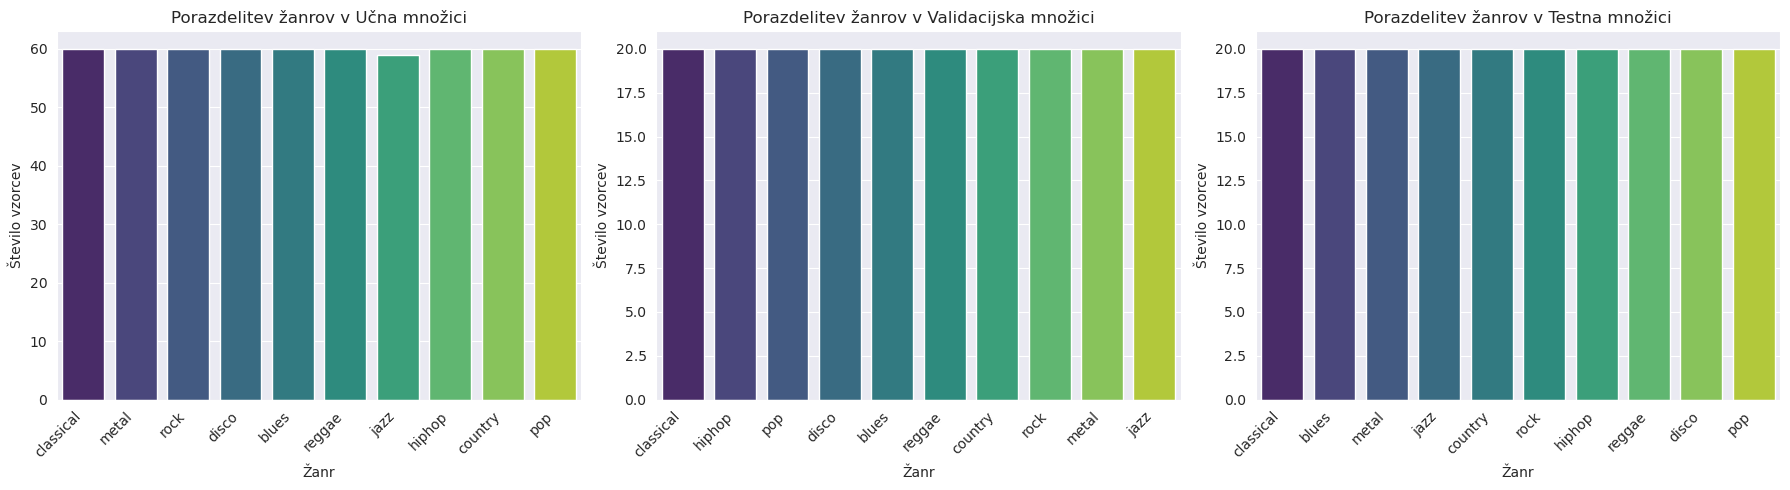


--- 2.1 Priprava podatkov za MLP ---
Ekstrahiranje MLP značilnic...
Ekstrahiram MLP značilnice za classical.00024.wav (1/599)


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- GLOBALNE NASTAVITVE ---
GTZAN_DIR = './gtzan/genres_original' # Pot do razpakiranega GTZAN nabora
MODELS_DIR = './models'
DATA_DIR = './data'
RADIO_AUDIO_DIR = '../audio_radio_samples'

SAMPLE_RATE = 22050
N_MFCC = 20
N_FFT = 2048
HOP_LENGTH = 512

# Parametri za Mel-spektrogram (za CNN)
N_MELS = 128
CNN_SEGMENT_LENGTH_SEC = 3

# Hiper-parametri za urjenje
LEARNING_RATE = 0.001
BATCH_SIZE_MLP = 32
BATCH_SIZE_CNN = 16
EPOCHS = 100
PATIENCE = 10

# Ustvari potrebne mape
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RADIO_AUDIO_DIR, exist_ok=True) # Za shranjevanje radio posnetkov

# --- FUNKCIJE ZA PRIPRAVO PODATKOV ---
def prepare_mlp_data(X_filepaths, y_labels, label_encoder, data_filename):
    features_list = []
    labels_list = []
    for i, filepath in enumerate(X_filepaths):
        print(f"Ekstrahiram MLP značilnice za {os.path.basename(filepath)} ({i+1}/{len(X_filepaths)})")
        features = extract_mlp_features(filepath, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
        if features is not None:
            features_list.append(features)
            labels_list.append(y_labels.iloc[i]) # Uporabite .iloc za Series

    # Preverite, ali so vse značilnice enake dolžine
    if len(features_list) == 0:
        print("Ni uspelo ekstrahirati nobenih MLP značilnic.")
        return None, None

    feature_dim = features_list[0].shape[0]
    for i, f in enumerate(features_list):
        if f.shape[0] != feature_dim:
            print(f"Opozorilo: Značilnica {i} ima drugačno dimenzijo ({f.shape[0]}) kot prva ({feature_dim}). Preskakujem.")
            features_list[i] = None # Označi kot neveljavno
    features_list = [f for f in features_list if f is not None] # Odstrani neveljavne

    X_processed = np.array(features_list)
    y_encoded = label_encoder.transform(labels_list) # Uporabi label_encoder

    save_processed_data({'features': X_processed, 'labels': y_encoded}, data_filename)
    return X_processed, y_encoded

def prepare_cnn_data(X_filepaths, y_labels, label_encoder, data_filename):
    all_segments = []
    all_segment_labels = []
    dummy_signal = np.zeros(int(CNN_SEGMENT_LENGTH_SEC * SAMPLE_RATE))
    dummy_mel_spec = extract_cnn_features_mel_spectrogram(y=dummy_signal, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    if dummy_mel_spec is None:
        raise ValueError("Ni mogoče izračunati dimenzije dummy Mel-spektrograma. Preverite parametre.")
    expected_frames = dummy_mel_spec.shape[1]
    print(f"Pričakovano število časovnih okvirjev za {CNN_SEGMENT_LENGTH_SEC}s segment: {expected_frames}")

    for i, filepath in enumerate(X_filepaths):
        print(f"Ekstrahiram CNN značilnice za {os.path.basename(filepath)} ({i+1}/{len(X_filepaths)})")
        try:
            y, sr_orig = librosa.load(filepath, sr=SAMPLE_RATE)
            if sr_orig != SAMPLE_RATE:
                y = librosa.resample(y, orig_sr=sr_orig, target_sr=SAMPLE_RATE)

            total_duration = librosa.get_duration(y=y, sr=SAMPLE_RATE)
            num_segments = int(total_duration / CNN_SEGMENT_LENGTH_SEC)

            for j in range(num_segments):
                start_sample = int(j * CNN_SEGMENT_LENGTH_SEC * SAMPLE_RATE)
                end_sample = int((j + 1) * CNN_SEGMENT_LENGTH_SEC * SAMPLE_RATE)
                segment_y = y[start_sample:end_sample]

                if len(segment_y) < int(CNN_SEGMENT_LENGTH_SEC * SAMPLE_RATE * 0.9): # Prekratke segmente izpustimo
                    continue

                mel_spectrogram_db = extract_cnn_features_mel_spectrogram(y=segment_y, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

                if mel_spectrogram_db is not None:
                    if mel_spectrogram_db.shape[1] > expected_frames:
                        mel_spectrogram_db = mel_spectrogram_db[:, :expected_frames]
                    elif mel_spectrogram_db.shape[1] < expected_frames:
                        padding = expected_frames - mel_spectrogram_db.shape[1]
                        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, padding)), mode='constant')

                    all_segments.append(np.expand_dims(mel_spectrogram_db, axis=-1))
                    all_segment_labels.append(y_labels.iloc[i]) # Labela celotne pesmi za ta segment

        except Exception as e:
            print(f"Napaka pri obdelavi {filepath}: {e}")
            continue

    if len(all_segments) == 0:
        print("Ni uspelo ekstrahirati nobenih CNN segmentov.")
        return None, None

    X_processed = np.array(all_segments)
    y_encoded = label_encoder.transform(all_segment_labels)

    save_processed_data({'features': X_processed, 'labels': y_encoded}, data_filename)
    return X_processed, y_encoded


# --- GLAVNI DEL APLIKACIJE ---
if __name__ == "__main__":
    print("--- 1. Priprava podatkov GTZAN ---")
    df_gtzan = load_gtzan_data(GTZAN_DIR)
    genres = sorted(df_gtzan['genre'].unique())
    num_classes = len(genres)
    print(f"Najdeni žanri: {genres}")

    label_encoder = LabelEncoder()
    label_encoder.fit(genres)
    save_processed_data(label_encoder, os.path.join(DATA_DIR, 'label_encoder.pkl'))
    print("LabelEncoder shranjen.")

    # Delitev podatkov
    (X_train_paths, y_train_labels), (X_val_paths, y_val_labels), (X_test_paths, y_test_labels) = \
        split_data(df_gtzan, test_size=0.2, val_size=0.25) # 0.25 * 0.8 = 0.2 celotnega za validacijo

    # Preverite porazdelitev žanrov
    print("\nPreverjanje porazdelitve žanrov v deljenih množicah:")
    plot_genre_distribution([y_train_labels, y_val_labels, y_test_labels], ['Učna', 'Validacijska', 'Testna'])

    # --- 2. Ekstrakcija in priprava značilnic za MLP ---
    print("\n--- 2.1 Priprava podatkov za MLP ---")
    mlp_train_data_path = os.path.join(DATA_DIR, 'mlp_train_data.pkl')
    mlp_val_data_path = os.path.join(DATA_DIR, 'mlp_val_data.pkl')
    mlp_test_data_path = os.path.join(DATA_DIR, 'mlp_test_data.pkl')

    if os.path.exists(mlp_train_data_path) and os.path.exists(mlp_val_data_path) and os.path.exists(mlp_test_data_path):
        print("Nalaganje predhodno obdelanih MLP podatkov...")
        mlp_train_data = load_processed_data(mlp_train_data_path)
        mlp_val_data = load_processed_data(mlp_val_data_path)
        mlp_test_data = load_processed_data(mlp_test_data_path)
        X_train_mlp, y_train_mlp = mlp_train_data['features'], mlp_train_data['labels']
        X_val_mlp, y_val_mlp = mlp_val_data['features'], mlp_val_data['labels']
        X_test_mlp, y_test_mlp = mlp_test_data['features'], mlp_test_data['labels']
    else:
        print("Ekstrahiranje MLP značilnic...")
        X_train_mlp, y_train_mlp = prepare_mlp_data(X_train_paths, y_train_labels, label_encoder, mlp_train_data_path)
        X_val_mlp, y_val_mlp = prepare_mlp_data(X_val_paths, y_val_labels, label_encoder, mlp_val_data_path)
        X_test_mlp, y_test_mlp = prepare_mlp_data(X_test_paths, y_test_labels, label_encoder, mlp_test_data_path)

    # Preverite, če so podatki dejansko na voljo
    if X_train_mlp is None or X_val_mlp is None or X_test_mlp is None:
        print("Napaka pri pripravi MLP podatkov. Prekinjam.")
        exit()

    # --- 3. Urjenje in evaluacija MLP modela ---
    print("\n--- 3.1 Urjenje MLP modela ---")
    mlp_input_shape = (X_train_mlp.shape[1],) # MLP pričakuje 1D vektor
    mlp_model = build_mlp_model(mlp_input_shape, num_classes)
    mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    mlp_model.summary()

    # Callbacks za MLP
    mlp_early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    mlp_checkpoint_path = os.path.join(MODELS_DIR, 'mlp_best_model.h5')
    mlp_model_checkpoint = ModelCheckpoint(filepath=mlp_checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    print("Začenjam urjenje MLP modela...")
    mlp_history = mlp_model.fit(X_train_mlp, y_train_mlp,
                                 batch_size=BATCH_SIZE_MLP,
                                 epochs=EPOCHS,
                                 validation_data=(X_val_mlp, y_val_mlp),
                                 callbacks=[mlp_early_stopping, mlp_model_checkpoint],
                                 verbose=1)

    print("Urjenje MLP modela zaključeno.")
    plot_training_history(mlp_history, "MLP")

    print("\n--- 3.2 Evaluacija MLP modela na testni množici ---")
    mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
    print(f"MLP Testna izguba: {mlp_test_loss:.4f}")
    print(f"MLP Testna natančnost: {mlp_test_accuracy:.4f}")

    mlp_predictions = np.argmax(mlp_model.predict(X_test_mlp), axis=1)
    plot_confusion_matrix(y_test_mlp, mlp_predictions, labels=label_encoder.classes_, model_name="MLP")

    # --- 4. Ekstrakcija in priprava značilnic za CNN ---
    print("\n--- 4.1 Priprava podatkov za CNN ---")
    cnn_train_data_path = os.path.join(DATA_DIR, 'cnn_train_data.pkl')
    cnn_val_data_path = os.path.join(DATA_DIR, 'cnn_val_data.pkl')
    cnn_test_data_path = os.path.join(DATA_DIR, 'cnn_test_data.pkl')

    if os.path.exists(cnn_train_data_path) and os.path.exists(cnn_val_data_path) and os.path.exists(cnn_test_data_path):
        print("Nalaganje predhodno obdelanih CNN podatkov...")
        cnn_train_data = load_processed_data(cnn_train_data_path)
        cnn_val_data = load_processed_data(cnn_val_data_path)
        cnn_test_data = load_processed_data(cnn_test_data_path)
        X_train_cnn, y_train_cnn = cnn_train_data['features'], cnn_train_data['labels']
        X_val_cnn, y_val_cnn = cnn_val_data['features'], cnn_val_data['labels']
        X_test_cnn, y_test_cnn = cnn_test_data['features'], cnn_test_data['labels']
    else:
        print("Ekstrahiranje CNN značilnic (Mel-spektrogrami) in delitev na segmente...")
        X_train_cnn, y_train_cnn = prepare_cnn_data(X_train_paths, y_train_labels, label_encoder, cnn_train_data_path)
        X_val_cnn, y_val_cnn = prepare_cnn_data(X_val_paths, y_val_labels, label_encoder, cnn_val_data_path)
        X_test_cnn, y_test_cnn = prepare_cnn_data(X_test_paths, y_test_labels, label_encoder, cnn_test_data_path)

    # Preverite, če so podatki dejansko na voljo
    if X_train_cnn is None or X_val_cnn is None or X_test_cnn is None:
        print("Napaka pri pripravi CNN podatkov. Prekinjam.")
        exit()

    # --- 5. Urjenje in evaluacija CNN modela ---
    print("\n--- 5.1 Urjenje CNN modela ---")
    cnn_input_shape = X_train_cnn.shape[1:] # (n_mels, n_frames, 1)
    cnn_model = build_cnn_model(cnn_input_shape, num_classes)
    cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    cnn_model.summary()

    # Callbacks za CNN
    cnn_early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    cnn_checkpoint_path = os.path.join(MODELS_DIR, 'cnn_best_model.h5')
    cnn_model_checkpoint = ModelCheckpoint(filepath=cnn_checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    print("Začenjam urjenje CNN modela...")
    cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn,
                                 batch_size=BATCH_SIZE_CNN,
                                 epochs=EPOCHS,
                                 validation_data=(X_val_cnn, y_val_cnn),
                                 callbacks=[cnn_early_stopping, cnn_model_checkpoint],
                                 verbose=1)

    print("Urjenje CNN modela zaključeno.")
    plot_training_history(cnn_history, "CNN")

    print("\n--- 5.2 Evaluacija CNN modela na testni množici ---")
    cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
    print(f"CNN Testna izguba: {cnn_test_loss:.4f}")
    print(f"CNN Testna natančnost: {cnn_test_accuracy:.4f}")

    cnn_predictions = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
    plot_confusion_matrix(y_test_cnn, cnn_predictions, labels=label_encoder.classes_, model_name="CNN")

    # --- 6. Klasifikacija internetnega radia (simulacija) ---
    print("\n--- 6. Klasifikacija 'internetnega radia' ---")
    # Pripravite nekaj dolgih .wav datotek (nad 60 sekund) v mapi `audio_radio_samples/`
    # Za primer, tukaj uporabljam dummy imena. Zamenjajte jih z vašimi dejanskimi datotekami.
    radio_songs_to_classify = [
        os.path.join(RADIO_AUDIO_DIR, 'song_rock_example.wav'),
        os.path.join(RADIO_AUDIO_DIR, 'song_jazz_example.wav'),
        os.path.join(RADIO_AUDIO_DIR, 'song_metal_example.wav'),
        os.path.join(RADIO_AUDIO_DIR, 'song_hiphop_example.wav'),
        os.path.join(RADIO_AUDIO_DIR, 'song_classical_example.wav'),
    ]

    for i, radio_song_path in enumerate(radio_songs_to_classify):
        print(f"\nKlasificiram pesem {i+1}/{len(radio_songs_to_classify)}: {os.path.basename(radio_song_path)}")
        final_genre, segment_results = classify_radio_stream(
            audio_path=radio_song_path,
            model_path=cnn_checkpoint_path, # Uporabi shranjen najboljši CNN model
            label_encoder_path=os.path.join(DATA_DIR, 'label_encoder.pkl'),
            segment_length_sec=CNN_SEGMENT_LENGTH_SEC,
            sr=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS
        )
        if final_genre:
            print(f"Končni klasifikacijski rezultat za '{os.path.basename(radio_song_path)}': {final_genre}")
            # Tukaj dodajte ročni vnos ali avtomatizirano pridobivanje pravega žanra (npr. iz metadata ali Chosic)
            # In komentar, zakaj mislite, da je rezultat pravilen/napačen.
            # Primer:
            # actual_genre = "Rock" # Pridobite to informacijo ročno
            # print(f"Dejanski žanr: {actual_genre}")
            # print("Komentar: Model je pravilno prepoznal rock, saj je pesem vsebovala močne kitarske rife in bobne.")
            print("-" * 50)